# 通过神经网络预测房价

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [28]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [29]:
print('一共有 {} 个训练集样本'.format(train.shape[0]))
print('一共有 {} 个测试集样本'.format(test.shape[0]))

一共有 1460 个训练集样本
一共有 1459 个测试集样本


数据处理，取出**第二个**       到     **倒数第二个特征**，作为神经网络的特征输入

In [30]:
all_features = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                         test.loc[:,'MSSubClass':'SaleCondition']))

对数值特征**标准化**：减去均值，除以方差

In [31]:
numeric_feats = all_features.dtypes[all_features.dtypes != "object"].index
all_features[numeric_feats] = all_features[numeric_feats].apply(lambda x:(x-x.mean())/(x.std()))

In [48]:
# 对预测的价格取 log
train['SalePrice'] = np.log(train['SalePrice'])

对预测的价格取对数

**编码非数值特征: **
如果你仔细看看上面的特征，你会发现，除了数值特征之外，还有很多非数值特征，这些特征我们没有办法将其转换成数值表示，所以我们通过 pandas 的内置函数将其转换成种类表示

比如 **MSZoning** 有两种可能，一种是 RL，一种是 RM，那么我们就将这个特征变成两个新的特征，RL 和 RM，如果这个数据在 **MSZoning** 上是 RL，那么 RL 取 1，RM 取 0；反之如果这个特征是 RM，那么 RL 取 0，RM 取 1.

| RL | RM |
|-|-|
| 0 | 1 |
| 1 | 0 |

In [49]:
all_features = pd.get_dummies(all_features, dummy_na=True)

**填充缺省值: **除此之外，我们会发现整个数据中有一些丢失数据，这些丢失数据都是 'NA'，我们没有办法将这些数据输入到网络中，所以需要对这些丢失数据进行赋值，这里我们将数据的均值填入到丢失数据中

In [50]:
all_features = all_features.fillna(all_features.mean())
feat_dim = all_features.shape[1]

处理完成。将训练集和验证集都取出成一个numpy array

In [51]:
#划分训练样本和验证样本
num_train = int(0.9 * train.shape[0])
indices = np.arange(train.shape[0])
np.random.shuffle(indices)

train_indices = indices[:num_train]
valid_indices = indices[num_train:]

#提取训练集和验证集特征
train_features = all_features.iloc[train_indices].values.astype(np.float32)
train_features = torch.from_numpy(train_features)
valid_features = all_features.iloc[valid_indices].values.astype(np.float32)
valid_features = torch.from_numpy(valid_features)
train_valid_features = all_features[:train.shape[0]].values.astype(np.float32)
train_valid_features = torch.from_numpy(train_valid_features)

#提取训练集和验证集的label
train_labels = train['SalePrice'].values[train_indices, None].astype(np.float32)
train_labels = torch.from_numpy(train_labels)
valid_labels = train['SalePrice'].values[valid_indices, None].astype(np.float32)
valid_labels = torch.from_numpy(valid_labels)
train_valid_labels = train['SalePrice'].values[:, None].astype(np.float32)
train_valid_labels = torch.from_numpy(train_valid_labels)


In [52]:
test_features = all_features[train.shape[0]:].values.astype(np.float32)
test_features = torch.from_numpy(test_features)

## 构建神经网络

In [53]:
def get_model():
    net = nn.Sequential(
            nn.Linear(feat_dim,1)
    )
    return net
net = get_model()
print(net)

Sequential(
  (0): Linear(in_features=331, out_features=1, bias=True)
)


在评估模型的时候，为了保证大的价格和小的价格对模型都有着近似相同的影响，我们不会直接使用前面定义的均方误差作为最后的评价函数，我们会对预测的价格和真实的价格取 log，然后计算他们之间均方误差的平方根来作为评价指标，这里的指标我们已经在 `utils.py` 中实现了，感兴趣的同学可以去看看。

In [54]:
from utils import train_model,pred

epoch: 10, train rmse: 0.181, valid rmse: 0.210

epoch: 20, train rmse: 0.142, valid rmse: 0.191

epoch: 30, train rmse: 0.122, valid rmse: 0.187

epoch: 40, train rmse: 0.111, valid rmse: 0.188

epoch: 50, train rmse: 0.105, valid rmse: 0.186

epoch: 60, train rmse: 0.100, valid rmse: 0.186

epoch: 70, train rmse: 0.097, valid rmse: 0.187

epoch: 80, train rmse: 0.095, valid rmse: 0.186

epoch: 90, train rmse: 0.094, valid rmse: 0.190

epoch: 100, train rmse: 0.093, valid rmse: 0.191



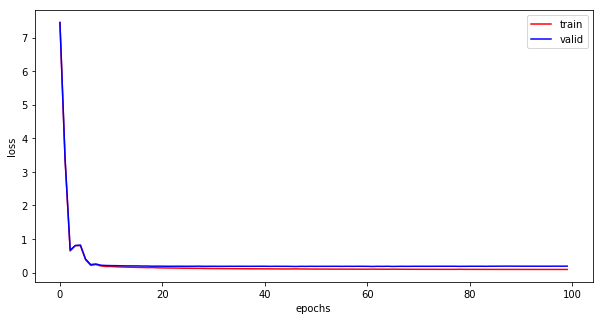

In [55]:
batch_size = 128
epochs = 100
lr = 0.01
wd = 0
use_gpu = True

net = get_model()
train_model(net,train_features,train_labels,valid_features,valid_labels,epochs,
           batch_size,lr,wd,use_gpu)

In [56]:
pred(net, test, test_features)